# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [5]:
!sh download_data.sh

--2023-02-16 15:54:09--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Распознаётся ufldl.stanford.edu (ufldl.stanford.edu)… 171.64.68.10
Подключение к ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 182040794 (174M) [text/plain]
Сохранение в: «train_32x32.mat»

train_32x32.mat     100%[===================>] 173,61M   421KB/s    за 5m 20s  

2023-02-16 15:59:29 (556 KB/s) - «train_32x32.mat» сохранён [182040794/182040794]

--2023-02-16 15:59:29--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Повторное использование соединения с ufldl.stanford.edu:80.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 64275384 (61M) [text/plain]
Сохранение в: «test_32x32.mat»

test_32x32.mat      100%[===================>]  61,30M  1,20MB/s    за 97s     

2023-02-16 16:01:06 (649 KB/s) - «test_32x32.mat» сохранён [64275384/64275384]

ЗАВЕРШЕНО --2023-02-16 16:01:06--
Общее время: 6m 57s
Загруж

In [6]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

/tmp/ipykernel_203360/2810386256.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
/tmp/ipykernel_203360/2810386256.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0


# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [7]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [8]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [9]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [10]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [11]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [12]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-4)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-3)


# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 43.578719, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 42.404436, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 41.492389, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 44.357768, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 41.036157, Train accuracy: 0.237111, val accuracy: 0.242000
Loss: 37.772634, Train accuracy: 0.269667, val accuracy: 0.266000
Loss: 41.495101, Train accuracy: 0.307000, val accuracy: 0.301000
Loss: 35.720808, Train accuracy: 0.370556, val accuracy: 0.361000
Loss: 36.817415, Train accuracy: 0.408333, val accuracy: 0.408000
Loss: 25.662095, Train accuracy: 0.460667, val accuracy: 0.461000
Loss: 31.806632, Train accuracy: 0.523778, val accuracy: 0.513000
Loss: 29.011691, Train accuracy: 0.561111, val accuracy: 0.559000
Loss: 28.024413, Train accuracy: 0.583000, val accuracy: 0.568000
Loss: 28.993912, Train accuracy: 0.618444, val accuracy: 0.592000
Loss: 24.738965, Train accuracy: 0.641222, val accuracy: 0.636000
Loss: 20.1

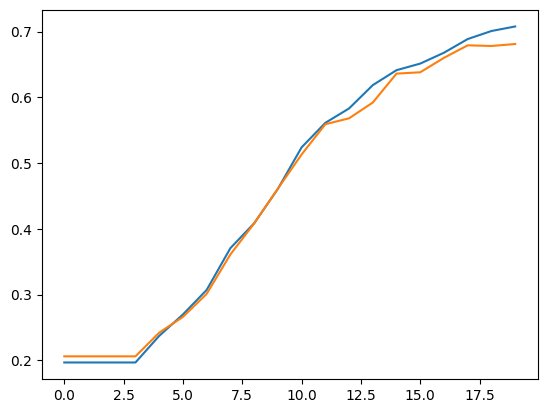

In [13]:
plt.plot(train_history)
plt.plot(val_history);

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [14]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 44.545313, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 48.250123, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 44.155414, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 44.658869, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 42.903496, Train accuracy: 0.213333, val accuracy: 0.219000
Loss: 40.100610, Train accuracy: 0.252111, val accuracy: 0.255000
Loss: 39.011602, Train accuracy: 0.277111, val accuracy: 0.273000
Loss: 45.163554, Train accuracy: 0.289222, val accuracy: 0.296000
Loss: 42.944123, Train accuracy: 0.341778, val accuracy: 0.331000
Loss: 40.985989, Train accuracy: 0.384111, val accuracy: 0.375000
Loss: 36.471396, Train accuracy: 0.414667, val accuracy: 0.402000
Loss: 35.843059, Train accuracy: 0.458333, val accuracy: 0.440000
Loss: 47.240086, Train accuracy: 0.490444, val accuracy: 0.464000
Loss: 27.847179, Train accuracy: 0.523556, val accuracy: 0.526000
Loss: 37.564342, Train accuracy: 0.546556, val accuracy: 0.537000
Loss: 33.9

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [15]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-3, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 40.678590, Train accuracy: 0.257556, val accuracy: 0.264000
Loss: 33.896634, Train accuracy: 0.469000, val accuracy: 0.460000
Loss: 32.891148, Train accuracy: 0.519778, val accuracy: 0.523000
Loss: 34.626102, Train accuracy: 0.561667, val accuracy: 0.558000
Loss: 35.606701, Train accuracy: 0.577778, val accuracy: 0.548000
Loss: 42.601410, Train accuracy: 0.544222, val accuracy: 0.550000
Loss: 32.364429, Train accuracy: 0.605556, val accuracy: 0.583000
Loss: 26.553279, Train accuracy: 0.565889, val accuracy: 0.555000
Loss: 35.171669, Train accuracy: 0.591667, val accuracy: 0.588000
Loss: 37.025801, Train accuracy: 0.632000, val accuracy: 0.618000
Loss: 30.480841, Train accuracy: 0.626889, val accuracy: 0.605000
Loss: 26.134400, Train accuracy: 0.614333, val accuracy: 0.608000
Loss: 27.488425, Train accuracy: 0.643889, val accuracy: 0.624000
Loss: 27.169720, Train accuracy: 0.623778, val accuracy: 0.631000
Loss: 39.473045, Train accuracy: 0.619444, val accuracy: 0.622000
Loss: 36.5

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [16]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 12.061030, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.360059, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 10.490006, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 19.791552, Train accuracy: 0.133333, val accuracy: 0.066667
Loss: 75.211562, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 37.765050, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: 582.247303, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.000000
Loss: inf, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.266667
Loss: inf, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.333333, val accuracy: 0.200000
Loss: inf, Train accuracy: 0.266667, val accuracy: 0.0666

/home/agat.local/s.bulganin/Рабочий стол/dl-course/assignment2/layers.py:58: RuntimeWarning: divide by zero encountered in log
  ans = -np.sum(np.log(probs[np.arange(len(target_index)), target_index.reshape(1, -1)]))


Loss: inf, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: inf, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: inf, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: inf, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: inf, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: inf, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.066667, val accuracy: 0.200000
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.200000
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: inf, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: inf, Train accuracy: 0.000000, val

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [17]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])

trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=0.01, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 11.498334, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.437618, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.045650, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.219905, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 10.848430, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11.352193, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 8.765546, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 9.612999, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 9.788985, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 8.001611, Train accuracy: 0.533333, val accuracy: 0.066667
Loss: 7.482139, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 6.212697, Train accuracy: 0.666667, val accuracy: 0.066667
Loss: 2.528047, Train accuracy: 0.666667, val accuracy: 0.066667
Loss: 3.902189, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 2.394499, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 1.765199, Tra

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [18]:
# learning_rates = [1e-1]
# reg_strengths = [0.1]
# learning_rate_decay = [0.999]
# hidden_layer_sizes = [100]
# num_epochs = [100]
# batch_sizes = [16]
# best_classifier = None
# best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

#for learning_rate in learning_rates:
#    for reg_strength in reg_strengths:
#        for hidden_layer_size in hidden_layer_sizes:
#            for num_epoch in num_epochs:
#                for batch_size in batch_sizes:
#                    
#                    model = TwoLayerNet(n_input = train_X.shape[1], 
#                                    n_output = 10, 
#                                   hidden_layer_size = hidden_layer_size, 
#                                    reg = reg_strength)
#                    dataset = Dataset(train_X, train_y, val_X, val_y)
#                    trainer = Trainer(model, dataset, MomentumSGD(), 
#                                     learning_rate=learning_rate, 
#                                      num_epochs=num_epoch, batch_size=batch_size)
#                    loss_history, train_history, val_history = trainer.fit()
#                    if best_classifier == None:
#                        best_classifier = model
#                        best_val_accuracy = val_history[-1]
#
#                    if best_val_accuracy<best_val_accuracy:
#                        best_classifier = model
#                        best_val_accuracy = val_history[-1]
#                        best_learning_rate = learning_rate
#                        best_reg_strength = reg_strength
#                        best_hidden_layer_size = hidden_layer_size
#                        best_num_epoch = num_epoch
#                    print('next')


model = TwoLayerNet(n_input = train_X.shape[1], 
                    n_output = 10, 
                    hidden_layer_size = 180,
                    reg = 1e-4)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-3, num_epochs=100)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()
best_classifier = model

Loss: 45.763641, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 42.041041, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 45.140739, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 43.811835, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 46.120512, Train accuracy: 0.242444, val accuracy: 0.249000
Loss: 34.496303, Train accuracy: 0.273778, val accuracy: 0.276000
Loss: 40.254305, Train accuracy: 0.326556, val accuracy: 0.335000
Loss: 38.786104, Train accuracy: 0.397000, val accuracy: 0.397000
Loss: 31.663654, Train accuracy: 0.449222, val accuracy: 0.448000
Loss: 26.985609, Train accuracy: 0.485111, val accuracy: 0.477000
Loss: 22.767420, Train accuracy: 0.539778, val accuracy: 0.531000
Loss: 29.081603, Train accuracy: 0.575333, val accuracy: 0.563000
Loss: 28.999811, Train accuracy: 0.612444, val accuracy: 0.590000
Loss: 18.702993, Train accuracy: 0.645333, val accuracy: 0.616000
Loss: 24.486192, Train accuracy: 0.665222, val accuracy: 0.647000
Loss: 20.2

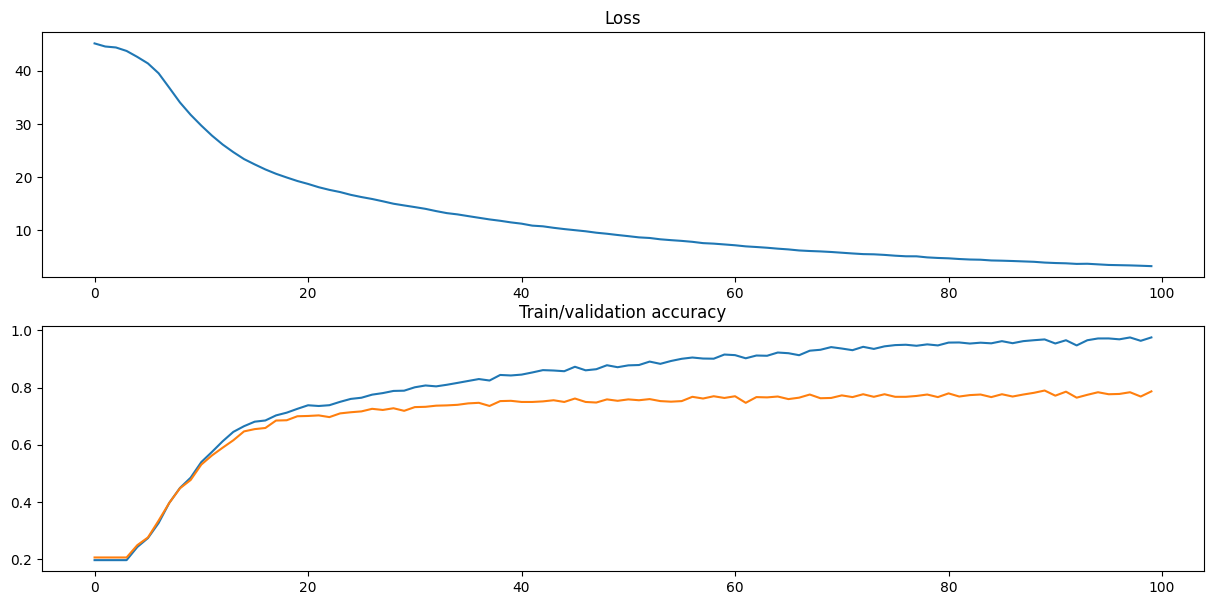

In [19]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history);

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [20]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.760000
